Multilayer Perceptron
===

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchmetrics import Accuracy,Precision, Recall

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


# Transformaciones para preprocesar los datos
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Cargar el conjunto de datos MNIST
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Crear los dataloaders para el entrenamiento y la prueba
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)




class MyForwarBackwardFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
       #sigmoid
        output= torch.sigmoid(input)
        ctx.save_for_backward(input)
        return output


    @staticmethod
    def backward(ctx, grad_output):
        # Implementa la operación backward personalizada
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input, = ctx.saved_tensors
        grad_input = grad_output * torch.sigmoid(input) * (1 - torch.sigmoid(input))
        return grad_input
    


class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        # Get Cuda device 
        cuda = torch.device('cuda')

        # Podemos definir las capas  de la red como nn.Linear o como nn.Parameter (esto ya inicializa los parámetros ej los pesos)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)


        # esto es para inicializar los pesos de las capas aleatoriamente usando nn.Parameter
        '''
        # Dimensions for input, hidden and output
        self.input_dim = input_size
        self.hidden_dim = hidden_size
        self.output_dim = output_size
        torch.cuda.seed_all()
        self.fc1 = torch.nn.Parameter(torch.randn(self.input_dim, self.hidden_dim, device=cuda,\
                                       requires_grad=True))
        self.fc2 = torch.nn.Parameter(torch.randn(self.hidden_dim, self.output_dim, device=cuda,\
                                       requires_grad=True))
        self.fc1 = torch.nn.Parameter(torch.randn_like(self.fc1, device=device, requires_grad=True))
        self.fc2 = torch.nn.Parameter(torch.randn_like(self.fc2, device=device, requires_grad=True))
        '''




        self.activation = MyForwarBackwardFunction.apply
        #self.activation = nn.Sigmoid()

    def forward(self, x):
        # Implementa la operación forward cuando se usa nn.Linear
        x = self.activation(self.fc1(x))
        x = self.fc2(x)

        # Implementa la operación forward cuando se usa nn.Parameter
        #x= self.activation(torch.mm(x, self.fc1))
        #x= torch.mm(x, self.fc2)
        return x


# Datos de ejemplo
input_size = 28 * 28  # Tamaño de las imágenes MNIST
hidden_size = 128
output_size = 10  # Número de clases en MNIST

# Crear el modelo MLP
model = MLP(input_size, hidden_size, output_size)
model.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

#inicalizamos listas para metricas
accuracy = Accuracy(num_classes=10,average='macro',task='multiclass') 
precision = Precision(num_classes=10, average='macro',task='multiclass') 
recall = Recall(num_classes=10, average='macro',task='multiclass') 
acc_list = [] 
prec_list = [] 
rec_list = [] 

#save metrics in cuda 
accuracy.to(device)
precision.to(device)
recall.to(device)


# Entrenamiento
iteracion = 0
for epoch in range(3):  # Ejemplo de entrenamiento con 10 épocas
    for inputs, labels in train_loader:
        inputs = inputs.view(-1, input_size)  # Aplanar las imágenes en un vector

        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f'Loss: {loss.item()}')

        iteracion += 1
        if iteracion % 50 == 0:
            _, predicted = torch.max(outputs.data, 1)

            #compute metrics
            acc = accuracy(predicted, labels) 
            prec = precision(predicted, labels) 
            rec = recall(predicted, labels) 

            # Store metrics
            acc_list.append(acc.item()) 
            prec_list.append(prec.item()) 
            rec_list.append(rec.item()) 


    '''# Evaluación en el conjunto de prueba
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.view(-1, input_size)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            #compute metrics
            acc = accuracy(predicted, labels) 
            prec = precision(predicted, labels) 
            rec = recall(predicted, labels) 

            # Store metrics
            acc_list.append(acc.item()) 
            prec_list.append(prec.item()) 
            rec_list.append(rec.item()) '''
            	

    # Imprimir el progreso del entrenamiento
    print(f'Epoch: {epoch+1}')




cuda:0
Loss: 2.434152364730835
Loss: 2.359187602996826
Loss: 2.3017807006835938
Loss: 2.3276729583740234
Loss: 2.2616944313049316
Loss: 2.2988898754119873
Loss: 2.273472785949707
Loss: 2.3310914039611816
Loss: 2.3257107734680176
Loss: 2.3115651607513428
Loss: 2.382319211959839
Loss: 2.343489408493042
Loss: 2.3343021869659424
Loss: 2.2265989780426025
Loss: 2.326836585998535
Loss: 2.2471060752868652
Loss: 2.3028180599212646
Loss: 2.2383389472961426
Loss: 2.254379987716675
Loss: 2.260601043701172
Loss: 2.257852792739868
Loss: 2.251997232437134
Loss: 2.2293736934661865
Loss: 2.269388198852539
Loss: 2.2735133171081543
Loss: 2.2973473072052
Loss: 2.2931621074676514
Loss: 2.2763473987579346
Loss: 2.261899948120117
Loss: 2.2239561080932617
Loss: 2.2433159351348877
Loss: 2.2155301570892334
Loss: 2.229104995727539
Loss: 2.21907114982605
Loss: 2.203585386276245
Loss: 2.1941797733306885
Loss: 2.264397621154785
Loss: 2.26969575881958
Loss: 2.266608476638794
Loss: 2.1869404315948486
Loss: 2.21322154

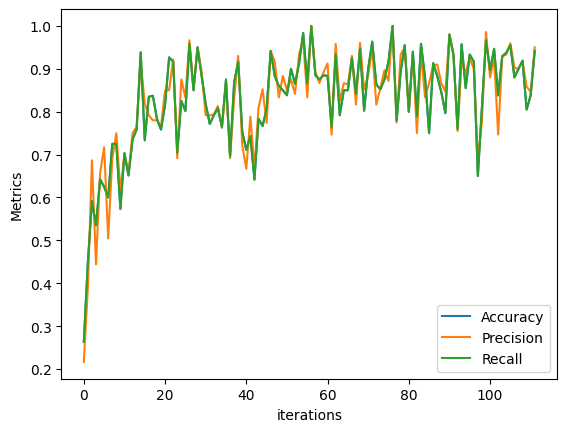

In [45]:
 
import matplotlib.pyplot as plt 
plt.figure() 
plt.plot(acc_list, label='Accuracy') 
plt.plot(prec_list, label='Precision') 
plt.plot(rec_list, label='Recall') 
plt.xlabel('iterations') 
plt.ylabel('Metrics') 
plt.legend() 
plt.show() 

Logistic Regression
===

In [52]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

# Descarga y carga los datos de entrenamiento de MNIST
train_dataset = MNIST(root='./data', train=True, transform=ToTensor(), download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define el modelo Logistic Regression
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.linear(x)

# Configuración del modelo
input_size = 28 * 28  # Tamaño de la imagen en MNIST
num_classes = 10  # Número de clases en MNIST

model = LogisticRegression(input_size, num_classes)

# Función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)


#inicalizamos listas para metricas
accuracy_logistic = Accuracy(num_classes=10,average='macro',task='multiclass') 
precision_logistic = Precision(num_classes=10, average='macro',task='multiclass') 
recall_logistic = Recall(num_classes=10, average='macro',task='multiclass') 
acc_list_logistic = [] 
prec_list_logistic = [] 
rec_list_logistic = [] 

#save metrics in cuda 


# Entrenamiento del modelo
num_epochs = 2
iteracion = 0
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images = images.reshape(-1, input_size)
     

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        iteracion += 1
        if iteracion % 50 == 0:
            _, predicted = torch.max(outputs.data, 1)

            #compute metrics
            acc = accuracy_logistic(predicted, labels) 
            prec = precision_logistic(predicted, labels) 
            rec = recall_logistic(predicted, labels) 

            # Store metrics
            acc_list_logistic.append(acc.item()) 
            prec_list_logistic.append(prec.item()) 
            rec_list_logistic.append(rec.item()) 

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
    #calculamos accucary




Epoch [1/2], Loss: 0.49856802821159363
Epoch [2/2], Loss: 0.39857932925224304


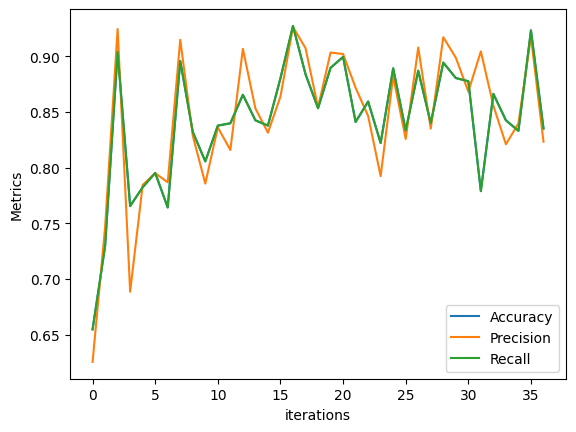

In [53]:
import matplotlib.pyplot as plt 
plt.figure() 
plt.plot(acc_list_logistic, label='Accuracy') 
plt.plot(prec_list_logistic, label='Precision') 
plt.plot(rec_list_logistic, label='Recall') 
plt.xlabel('iterations') 
plt.ylabel('Metrics') 
plt.legend() 
plt.show() 